# Huiswerkopgave - Old or Not

### Notebook by `Esmee Kraan, s1173469`

#### Gemaakt met behulp van chatGPT
---

## Table of contents

1. [Introduction](#Introduction)

2. [The problem domain](#The-problem-domain)

3. [Business Understanding](#Business-Understanding)

4. [Required libraries](#Required-libraries)

5. [Data Understanding](#Data-Understanding)

6. [Data Prepartion](#Data-Preparation)

7. [Modeling](#Modeling)

8. [Evaluation](#Evaluation)

9. [Reproducibility](#Reproducibility)

10. [Reference](#Reference)
---

# Introduction

[[ go back to the top ]](#Table-of-contents)

In deze notebook gaan we een neuraal netwerk bouwen dat kan bepalen of een beroemdheid jonger of ouder is dan 42 jaar. Het doel is om een model te trainen dat gezichten kan classificeren als 'not old' (tussen 21 en 42 jaar) of 'old' (ouder dan 42 jaar). We maken gebruik van de IMDB Faces Dataset, die meer dan 460.000 afbeeldingen bevat van beroemdheden met informatie over leeftijd en geslacht.

---

# The problem domain

[[ go back to the top ]](#Table-of-contents)

Dit project draait om leeftijdsclassificatie met behulp van gezichtsafbeeldingen van beroemdheden. Het bepalen van de leeftijd van volwassen beroemdheden op basis van hun uiterlijk kan lastig zijn voor mensen. We willen onderzoeken of een neuraal netwerk beter in staat is om te bepalen of iemand ouder is dan 42 jaar. 

We maken gebruik van de IMDB-WIKI dataset, één van de grootste publieke datasets met gezichtsafbeeldingen en leeftijdsinformatie. Deze dataset bevat gezichten van beroemdheden afkomstig van IMDB, inclusief metadata zoals leeftijd en geslacht. Voor dit project gebruiken we alleen de gegevens van volwassenen (21 jaar of ouder) en filteren we foto's waar meerdere gezichten of geen gezicht op staan.

De uitdaging in dit domein ligt niet alleen in de nauwkeurige classificatie van leeftijd, maar ook in het correct verwerken en filteren van de dataset. Door gebruik te maken van slechts 50.000 voorbeelden, willen we een model bouwen dat niet alleen goed presteert op de trainingsdata, maar ook goed generaliseert naar nieuwe, ongeziene afbeeldingen.

---

## Business Understanding: 
Van volwassen beroemdheden is het vaak lastig te zeggen hoe oud ze zijn. Nu gaan we kijken of we een neuraal netwerk kunnen bouwen wat dit beter kan schatten dan wij. We nemens als grens de compleet arbitraire waarde van 42 jaar. Iedereen tussen de 21 en 42 noemen we 'not old' en iedereen boven deze grens definieren we als 'old' 

We gebruiken hiervoor de IMDB faces database met daarin meer dan 460.000 gezichten van een dikke 20.000 beroemdheden afkomstig van IMDB (zie https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ voor uitleg en details) en hierbij de IMDB informatie over o.a. leeftijd en geslacht. We downloaden hier de de cropped IMDB dataset (https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar). De metadata wordt in .mat (matlab) bestand meegeleverd. 

- We beperken ons tot volwassen beroemdheden. <u>Iedereen onder de 21 jaar mag je overslaan.</u>
- Er zitten nogal wat foto's met meerdere gezichten of geen gezicht op. <u>Deze mag je eruit filteren</u>
- We verwachten niet alleen de code maar (in het notebook) ook een <u>uitleg</u> van waarom je dingen hebt gedaan. 
- I.v.m. performance issues gebruiken we na opschoning alleen de <u>1e 50.000</u> records als data
- Gebruik <u>20% van je data als testset, gebruik 42 als random state</u>
- Eindig met de mogelijkheid om een jpg van bijv. jezelf in te lezen en d.m.v. het getrainde netwerk te bepalen of diegene wel of niet oud is.

Vul je antwoorden steeds op de juiste plaats in. Maak indien nodig extra cellen aan.

# Required Libraries - WIP

[[ go back to the top ]](#Table-of-contents)

Voor dit project maken we gebruik van verschillende Python-pakketten die nodig zijn om de data te analyseren, te modelleren en te visualiseren. Als je deze nog niet hebt geïnstalleerd, kun je ze gemakkelijk installeren via `conda` of `pip`.

De primaire bibliotheken die we gebruiken zijn:

* **pandas**: Een krachtige bibliotheek voor het opslaan en manipuleren van data in DataFrames.
* **NumPy**: Biedt ondersteuning voor numerieke arrays en wiskundige operaties.
* **tensorflow**: Deze bibliotheek gebruiken we voor het bouwen van neurale netwerken en het trainen van ons classificatiemodel.
* **matplotlib**: Basisplottingbibliotheek voor het visualiseren van data.
* **IPython.display (Markdown)**: Hiermee kunnen we dynamische Markdown-inhoud in Jupyter Notebooks weergeven.

Om ervoor te zorgen dat alle benodigde bibliotheken zijn geïnstalleerd, kun je de volgende commando's gebruiken:

```bash
conda install pandas numpy pytz matplotlib
pip install pandas numpy pytz matplotlib
```

In [192]:
# Basis libraries voor data manipulatie en plotten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import datetime
from PIL import Image

# TensorFlow en Keras voor het bouwen van het neurale netwerk
import tensorflow as tf
from tensorflow.keras import datasets, layers, models # type: ignore

from sklearn.model_selection import train_test_split

# Data Understanding

[[ go back to the top ]](#Table-of-contents)

Voor zowel de IMDb- als Wikipedia-afbeeldingen wordt een apart `.mat`-bestand geleverd, dat kan worden geladen met Matlab en alle metadata bevat. Hieronder volgt een toelichting van de belangrijkste variabelen:

- **dob**: Dit staat voor de geboortedatum van de beroemdheid, opgeslagen als een Matlab-serieel datumgetal.
- **photo_taken**: Het jaar waarin de foto is genomen.
- **full_path**: Het pad naar de afbeeldingsbestanden.
- **gender**: Het geslacht van de beroemdheid, waarbij 0 voor vrouw en 1 voor man staat. Als het geslacht onbekend is, wordt deze waarde als `NaN` weergegeven.
- **name**: De naam van de beroemdheid.
- **face_location**: De locatie van het gezicht in de afbeelding. 
- **face_score:** Een score die aangeeft hoe goed de gezichtsdetector het gezicht heeft gedetecteerd; hoe hoger, hoe beter. Als de score Inf is, betekent dit dat er geen gezicht in de afbeelding is gevonden en geeft de face_location de gehele afbeelding terug.
- **second_face_score:** De score van een tweede gedetecteerd gezicht (indien aanwezig). Dit is nuttig om afbeeldingen met meerdere gezichten te negeren. Als er geen tweede gezicht is gevonden, is deze waarde NaN.
- **celeb_names (alleen IMDB):** Een lijst met de namen van alle beroemdheden in de dataset.
- **celeb_id (alleen IMDB):** Een index die verwijst naar de naam van een beroemdheid in de lijst met namen.

In Matlab kun je het gezicht bijsnijden door de volgende code te gebruiken:
  
```bash
img(face_location(2):face_location(4), face_location(1):face_location(3), :)
```

bron: https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ onder het kopje <u> Usage </u>

In [193]:
#Lees de metadata in, bestudeer deze en maak voor iedere relevante variabele een aparte list aan
# Laad het .mat bestand met metadata
mat = scipy.io.loadmat('../../bijlagen/imdb_crop/imdb.mat')

# Bekijk de sleutels in het geladen bestand om te begrijpen welke variabelen er beschikbaar zijn
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'imdb'])


Ik heb wat onderzoek gedaan wat deze keys betekenen en kwam op de volgende uitkomsten:
* __header__, __version__, __globals__: Deze komen vaak voor in .mat-bestanden en bevatten metadata over het bestand zelf (zoals versies en headers), wat meestal niet direct relevant is voor de analyse.
* `imdb:` Dit is de belangrijkste sleutel. Het bevat de daadwerkelijke dataset waar we mee gaan werken. We gebruiken deze variabele om toegang te krijgen tot de gegevens.

In [194]:
# Verkennen van een specifieke variabele in het bestand
imdb_data = mat['imdb']

# Bekijk de eerste sleutels en de structuur van de 'imdb' data
print(imdb_data.dtype)  # Dit laat zien wat voor soort data erin zit

[('dob', 'O'), ('photo_taken', 'O'), ('full_path', 'O'), ('gender', 'O'), ('name', 'O'), ('face_location', 'O'), ('face_score', 'O'), ('second_face_score', 'O'), ('celeb_names', 'O'), ('celeb_id', 'O')]


Hier kijkt ik nogmaals welke soort data er in zit, maar ik wist niet waar 'O' voor stond. Dus heb ik dat opgezocht:
* (`O`, wat voor object staat, vaak arrays of lijsten).
De betekenis achter elke variabele staat in de [Data Understanding](#Data-Understanding)

In [195]:
# kijken naar de geboortedatums (dob), geslachten (gender), en fotodata (photo_taken)
dob = imdb_data['dob'][0][0]
photo_taken = imdb_data['photo_taken'][0][0]
full_path = imdb_data['full_path'][0][0]
gender = imdb_data['gender'][0][0]
name = imdb_data['name'][0][0]
face_location = imdb_data['face_location'][0][0]
face_score = imdb_data['face_score'][0][0]
second_face_score = imdb_data['second_face_score'][0][0]
celeb_names = imdb_data['celeb_names'][0][0]
celeb_id = imdb_data['celeb_id'][0][0]

# Bekijk de eerste paar waarden
print(dob[:5])
print(photo_taken[:5])
print(full_path[:5])
print(gender[:5])
print(name[:5])
# print(face_location[:5])
# print(face_score[:5])
# print(second_face_score[:5])
# print(celeb_names[:5])
# print(celeb_id[:5])

[[693726 693726 693726 ... 726831 726831 726831]]
[[1968 1970 1968 ... 2011 2011 2011]]
[[array(['01/nm0000001_rm124825600_1899-5-10_1968.jpg'], dtype='<U43')
  array(['01/nm0000001_rm3343756032_1899-5-10_1970.jpg'], dtype='<U44')
  array(['01/nm0000001_rm577153792_1899-5-10_1968.jpg'], dtype='<U43')
  ...
  array(['08/nm3994408_rm926592512_1989-12-29_2011.jpg'], dtype='<U44')
  array(['08/nm3994408_rm943369728_1989-12-29_2011.jpg'], dtype='<U44')
  array(['08/nm3994408_rm976924160_1989-12-29_2011.jpg'], dtype='<U44')]]
[[1. 1. 1. ... 0. 0. 0.]]
[[array(['Fred Astaire'], dtype='<U12')
  array(['Fred Astaire'], dtype='<U12')
  array(['Fred Astaire'], dtype='<U12') ...
  array(['Jane Levy'], dtype='<U9') array(['Jane Levy'], dtype='<U9')
  array(['Jane Levy'], dtype='<U9')]]


In [196]:
# Inspecteer de vorm van enkele arrays
print("Shape of face_location:", face_location.shape)
print("Shape of face_score:", face_score.shape)
print("Shape of second_face_score:", second_face_score.shape)
print("Shape of dob:", dob.shape)
print("Shape of photo_taken:", photo_taken.shape)
print("Shape of full_path:", full_path.shape)
print("Shape of gender:", gender.shape)
print("Shape of name:", name.shape)
print("Shape of celeb_names:", celeb_names.shape)
print("Shape of celeb_id:", celeb_id.shape)

Shape of face_location: (1, 460723)
Shape of face_score: (1, 460723)
Shape of second_face_score: (1, 460723)
Shape of dob: (1, 460723)
Shape of photo_taken: (1, 460723)
Shape of full_path: (1, 460723)
Shape of gender: (1, 460723)
Shape of name: (1, 460723)
Shape of celeb_names: (1, 20284)
Shape of celeb_id: (1, 460723)


Wat me gelijk opvalt is hoe de geboortedatums zijn opgeslagen, op de website stond vermeld dat dit als 'Matlab-serieel datumgetal' is.

## Data preparation: 
Omdat we de leeftijd van de personen moeten omrekenen converteer ik de geboortedatums die zijn opgeslagen in Matlab's serial date nummer formaat naar Python's `datetime` objecten om ze leesbaar en bruikbaar te maken. Matlab serial date nummers zijn niet direct bruikbaar in Python. `matlab_datenum_to_date` zorgt ervoor dat we de datums omzetten naar een formaat dat we kunnen manipuleren en gebruiken in verdere analyses.


Daarna bereken ik de leeftijd van een persoon op basis van hun geboortedatum en het jaar waarin de foto is genomen met de functie `calculate_age`. Door de leeftijd te berekenen, kunnen we inzichten verkrijgen over de leeftijdsdistributie van de personen in de dataset.

Ook verwijder ik ongeldige leeftijdswaarden die ontstaan door foutieve of ontbrekende datums. Omdat negatieve leeftijden duiden op fouten in de gegevensverwerking. Het verwijderen van deze waarden zorgt ervoor dat de uiteindelijke dataset schoon en bruikbaar is voor verdere analyse en visualisatie.

In [197]:
# Omzetten van dob (geboortedatums) naar datetime objecten
def matlab_datenum_to_date(matlab_datenum):
    try:
        if matlab_datenum > 0:
            return datetime.datetime.fromordinal(int(matlab_datenum)) + datetime.timedelta(days=int(matlab_datenum) % 1) - datetime.timedelta(days=366)
        else:
            return None
    except OverflowError:
        return None

# Functie om de leeftijd te berekenen
def calculate_age(dob, photo_year):
    try:
        if dob is None or isinstance(dob, datetime.datetime) is False:
            return -1

        return photo_year - dob.year
    except Exception as e:
        print(f"Fout bij het berekenen van de leeftijd: {e}")
        return -1

# Converteer de geboortedatums naar datetime objecten
dob_converted = np.array([matlab_datenum_to_date(d) if not np.isnan(d) else None for d in dob.flatten()])

# Haal het jaar van de foto op
photo_year = photo_taken.flatten()

# Bereken de leeftijden, waarbij ongeldige datums en onbekende leeftijden worden afgehandeld
ages = np.array([calculate_age(d, y) for d, y in zip(dob_converted, photo_year)])

# Verwijder negatieve leeftijden (indien nodig)
ages = ages[ages != -1]

# print("Voorbeelden van ages:", ages[:10]) # Debug informatie: kijk naar enkele waarden van ages
# print(f"Grootte van de ages array: {ages.size}") # Debug: controleer de grootte van de ages array

#### Leeftijden filteren.
Ik verwijder alle leeftijden onder de 21 jaar omdat de opdracht was om ons te beperken tot volwassen beroemdheden. Ook filter ik onrealistische leeftijden eruit, uit onderzoek blijkt dat [Jeanne Calment](https://nl.wikipedia.org/wiki/Jeanne_Calment) uit Frankrijk het oudste persoon ooit is met 122 jaar. Daarom neem ik dat als mijn hoogste leeftijd.

In [198]:
# Filter de leeftijden om alleen waarden van 21 jaar en ouder te behouden
filtered_ages = ages[ages >= 21]

# Verwijder onrealistische leeftijden (bijv. boven 122 jaar)
filtered_ages = filtered_ages [filtered_ages  <= 122]

Minimale leeftijd: 21
Maximale leeftijd: 119
Gemiddelde leeftijd: 38.688233826395624
Standaardafwijking: 12.068945851105074


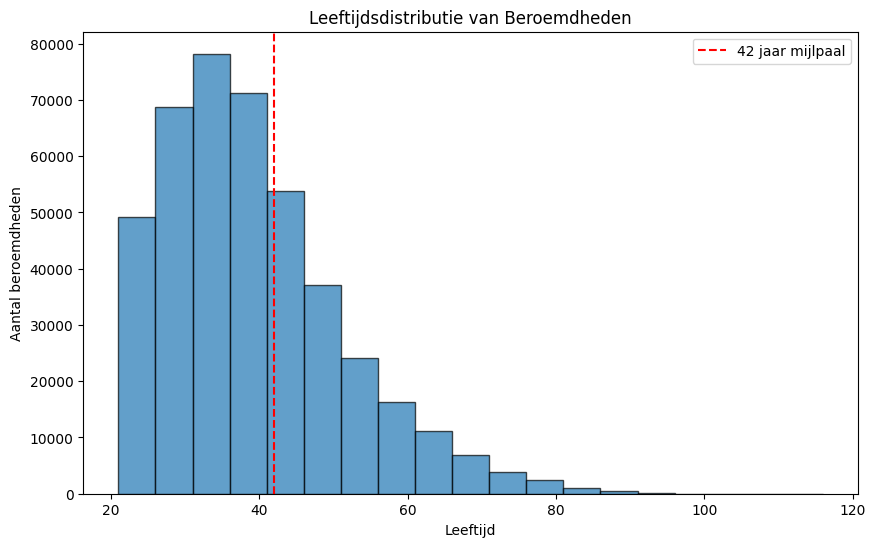

In [199]:
# Controleer de statistieken van de gefilterde leeftijden
print(f"Minimale leeftijd: {filtered_ages.min()}")
print(f"Maximale leeftijd: {filtered_ages.max()}")
print(f"Gemiddelde leeftijd: {filtered_ages.mean()}")
print(f"Standaardafwijking: {filtered_ages.std()}")

# Plot de histogram van de leeftijden
plt.figure(figsize=(10, 6))
plt.hist(filtered_ages, bins=range(21, 121, 5), edgecolor='black', alpha=0.7)

# Voeg een verticale lijn toe op 42
plt.axvline(x=42, color='red', linestyle='--', label='42 jaar mijlpaal')

# Voeg labels en titel toe
plt.xlabel('Leeftijd')
plt.ylabel('Aantal beroemdheden')
plt.title('Leeftijdsdistributie van Beroemdheden')
plt.legend()

# Toon de plot
plt.show()

Percentage onder 42 jaar: 65.70%
Percentage 42 jaar en ouder: 34.30%


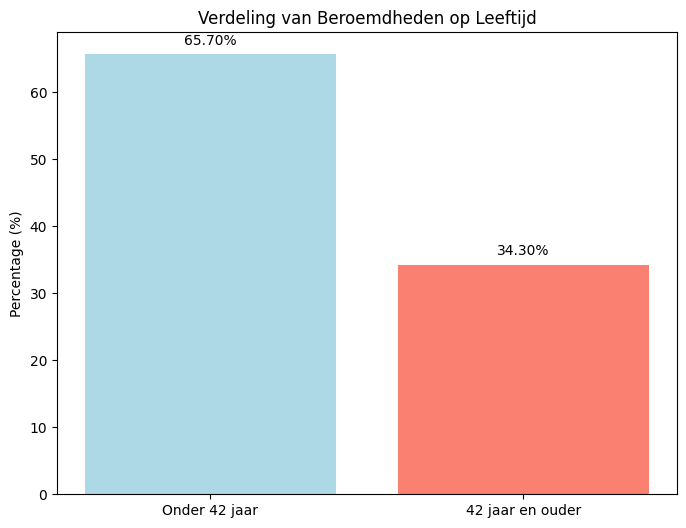

In [200]:
# Bereken percentages onder en boven 42 jaar
below_42 = np.sum(filtered_ages < 42)
above_42 = np.sum(filtered_ages >= 42)

total_count = len(filtered_ages)

percentage_below_42 = (below_42 / total_count) * 100
percentage_above_42 = (above_42 / total_count) * 100

# Print de percentages
print(f"Percentage onder 42 jaar: {percentage_below_42:.2f}%")
print(f"Percentage 42 jaar en ouder: {percentage_above_42:.2f}%")

# Visualiseer de verdeling met een staafdiagram
plt.figure(figsize=(8, 6))
categories = ['Onder 42 jaar', '42 jaar en ouder']
percentages = [percentage_below_42, percentage_above_42]

plt.bar(categories, percentages, color=['lightblue', 'salmon'])
plt.ylabel('Percentage (%)')
plt.title('Verdeling van Beroemdheden op Leeftijd')

# Voeg de percentages toe boven de staven
for i, percentage in enumerate(percentages):
    plt.text(i, percentage + 1, f'{percentage:.2f}%', ha='center', va='bottom') # type: ignore

plt.show()

Op basis van de dataset heb ik de volgende bevindingen:

- **Minimale leeftijd:** 21 jaar
- **Maximale leeftijd:** 119 jaar
- **Gemiddelde leeftijd:** Ongeveer 38.7 jaar
- **Standaardafwijking:** Ongeveer 12.1 jaar

Van de beroemdheden in de dataset:

- 65.70% is jonger dan 42 jaar.
- 34.30% is 42 jaar of ouder.

Deze verdeling geeft een goed overzicht van de leeftijdsopbouw van de beroemdheden in onze dataset, met een meerderheid die jonger is dan 42 jaar.

## Data Preprocessing

In [201]:
#voeg de ingelezen metadata en de berekende leeftijd samen tot een nieuwe dataset
dob = np.ravel(imdb_data['dob'][0][0])
photo_taken = np.ravel(imdb_data['photo_taken'][0][0])
full_path = np.ravel(imdb_data['full_path'][0][0])
gender = np.ravel(imdb_data['gender'][0][0])
face_score = np.ravel(imdb_data['face_score'][0][0])
second_face_score = np.ravel(imdb_data['second_face_score'][0][0])

data = {
    'file_path': full_path,
    'dob': dob,
    'photo_taken': photo_taken,
    'gender': gender,
    'face_score': face_score,
    'second_face_score': second_face_score,
}

df_imdb = pd.DataFrame(data)

In [202]:
# Converteer de 'dob' kolom naar datetime objecten
df_imdb['dob'] = [matlab_datenum_to_date(d) if not np.isnan(d) else None for d in df_imdb['dob']]

# Bereken leeftijden
photo_year = df_imdb['photo_taken']
ages = np.array([calculate_age(d, y) for d, y in zip(df_imdb['dob'], photo_year)])

# Converteer leeftijden naar gehele getallen
ages = np.floor(ages).astype(int)

# Voeg de leeftijden toe aan de DataFrame
df_imdb['age'] = ages

C:\Users\MSI\AppData\Local\Temp\ipykernel_936\2939377332.py:9: RuntimeWarning: invalid value encountered in cast
  ages = np.floor(ages).astype(int)


In [203]:
#schoon de dataset op op basis van de bij de business understanding gegeven criteria.
#check op dat het persoon op de foto ouder is dan 21 en jonger is dan 122
df_imdb = df_imdb[df_imdb['age'] >= 21]
df_imdb = df_imdb[df_imdb['age'] <= 122]

# Verwijder afbeeldingen zonder gezichten en met meerdere gezichten
# - face_score moet geen Inf zijn (anders geen gezicht gedetecteerd)
# - second_face_score moet NaN zijn (anders meerdere gezichten)
df_imdb_filtered = df_imdb[
    (df_imdb['face_score'] != np.inf) &
    (df_imdb['second_face_score'].isna())
]

Ik filter hier de dataset op basis van leeftijd en hoeveel gedecterde gezichten er zijn op de foto.

- **Minimale Leeftijd**: Beperk de dataset tot personen die 21 jaar of ouder zijn.
- **Maximale Leeftijd**: Beperk de dataset tot personen die 122 jaar of jonger zijn.

- **Geen Gezicht Gedetecteerd**: Verwijder afbeeldingen waar de `face_score` gelijk is aan `Inf`, wat aangeeft dat er geen gezicht is gedetecteerd.
- **Meerdere Gezichten**: Verwijder afbeeldingen waar de `second_face_score` een waarde heeft (d.w.z., niet NaN), wat betekent dat er meerdere gezichten zijn gedetecteerd.

De gefilterde DataFrame bevat nu alleen afbeeldingen met realistische leeftijden en met één goed gedetecteerd gezicht.

In [204]:
print(df_imdb.shape)
print(df_imdb_filtered.shape)

(424828, 7)
(227378, 7)


De filtering heeft geleid tot een vermindering van het aantal rijen in de dataset van 424,828 naar 227,378. Dit betekent dat ongeveer 45% van de oorspronkelijke data is uitgesloten op basis van de opgegeven criteria. Hierdoor is de dataset schoner en specifieker voor de analyse.

In [205]:
df_imdb_filtered.head()

,file_path,dob,photo_taken,gender,face_score,second_face_score,age
3,[01/nm0000001_rm946909184_1899-5-10_1968.jpg],1899-05-10,1968,1.0,1.872117,NaN,69
4,[01/nm0000001_rm980463616_1899-5-10_1968.jpg],1899-05-10,1968,1.0,1.158766,NaN,69
6,[02/nm0000002_rm1346607872_1924-9-16_2004.jpg],1924-09-16,2004,0.0,3.479189,NaN,80
7,[02/nm0000002_rm1363385088_1924-9-16_2004.jpg],1924-09-16,2004,0.0,3.870171,NaN,80
12,[02/nm0000002_rm221957120_1924-9-16_1974.jpg],1924-09-16,1974,0.0,4.096431,NaN,50


In [206]:
# Splits de gefilterde dataset in train- en testset
# 20% van de data wordt gebruikt als testset
# random_state=42 zorgt voor reproduceerbare splits
df_train, df_test = train_test_split(df_imdb_filtered, test_size=0.2, random_state=42)

# Print de vormen van de train- en testsets
print("Trainset vorm:", df_train.shape)
print("Testset vorm:", df_test.shape)

Trainset vorm: (181902, 7)
Testset vorm: (45476, 7)


In [207]:
# Lees de afbeeldingen in


## Modeling: 

In [208]:
#normaliseer de data, train het model en valideer dit op de testdata


## Evaluation: 

In [209]:
# plot de accuracy en validated accuracy, toon de confusion matrix,
# en toon de een aantal afbeeldingen inclusief of ze volgens het model wel of niet oud zijn,
# doe dit laatste ook voor een paar eigen afbeeldingen


Kunnen we met dit model betrouwbaar schatten of een beroemdheid oud is?
(type je antwoord en uitleg hieronder)

# Reference

- Rothe, R., Timofte, R., & Van Gool, L. (2018). *Deep expectation of real and apparent age from a single image without facial landmarks*. International Journal of Computer Vision, 126(2-4), 144–157. Springer.

- Rothe, R., Timofte, R., & Van Gool, L. (2015). *DEX: Deep EXpectation of apparent age from a single image*. In IEEE International Conference on Computer Vision Workshops (ICCVW), December.
